In [20]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import pandas as pd
import os
from keras import layers

from data_processing import *
from training_utils import *

from train_config import *
import json

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

CONFIG = get_config()[0]


In [2]:
CONFIG

{'DATA_PATH': 'data/flickr30k_images/',
 'IMAGES_PATH': 'data/flickr30k_images/flickr30k_images/',
 'IMAGE_SIZE': (224, 224),
 'VAL_FRACTION': 0.05,
 'SEQ_LENGTH': 32,
 'VOCAB_SIZE': 10000,
 'BATCH_SIZE': 128,
 'EPOCHS': 20,
 'STRIP_CHARS': '!"#$%&\'()*+,-./:;=?@[\\]^_`{|}~',
 'EMBED_DIM': 512,
 'FF_DIM': 256,
 'ENC_HEADS': 2,
 'DEC_HEADS': 2,
 'LR': 0.001,
 'ARTIFACT_DIR': 'artifacts'}

In [3]:
train_captionings_df = pd.read_csv("splits/train_captions.csv")
val_captionings_df = pd.read_csv("splits/val_captions.csv")




tokenizer = build_tokenizer(vocab_size=VOCAB_SIZE, seq_len=SEQ_LENGTH)
tokenizer.adapt(train_captionings_df["comment"].tolist())

def process_input(img_path, captions):
    return decode_and_resize(img_path, IMAGE_SIZE), tf.reshape(tokenizer(captions), shape=(1, SEQ_LENGTH))

def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset

val_dataset = make_dataset(train_captionings_df["image_name"].tolist(),
                             train_captionings_df["comment"].tolist())



2024-04-13 12:36:26.496390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 12:36:26.520794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 12:36:26.520908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### LOADING TRAINED MODEL



In [4]:
new_model = load_trained_model_weights("artifacts/model_weights.h5", CONFIG)

In [5]:
new_model.summary()

Model: "image_captioning_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 49, 1280)          6575239   
                                                                 
 transformer_encoder_block   multiple                  2760192   
 (TransformerEncoderBlock)                                       
                                                                 
 transformer_decoder_block   multiple                  14733840  
 (TransformerDecoderBlock)                                       
                                                                 
Total params: 24069275 (91.82 MB)
Trainable params: 17494032 (66.73 MB)
Non-trainable params: 6575243 (25.08 MB)
_________________________________________________________________


In [6]:
caption_model = new_model


In [11]:
vocab = tokenizer.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = val_captionings_df.iloc[1: 100]["image_name"].to_list()

import matplotlib.pyplot as plt
def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img, IMAGE_SIZE)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.figure(figsize=(6, 6))
    plt.imshow(img / 255.0)
    

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    
    img = caption_model.cnn_model(img)

    
    
    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = tokenizer([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "end":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace("end", "").strip()
    print("Predicted Caption: ", decoded_caption)

    plt.show()

Predicted Caption:  a man and a woman are sitting on a bench


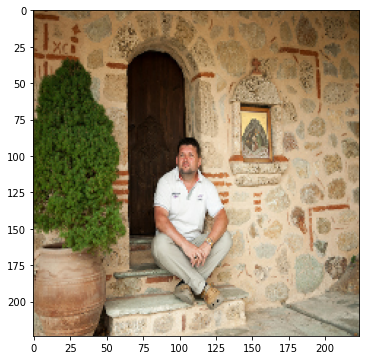

Predicted Caption:  a woman in a red shirt is holding a small child


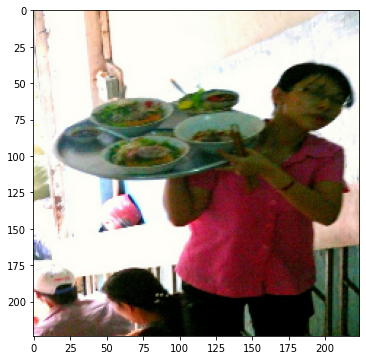

Predicted Caption:  a man in a white shirt is holding a serve


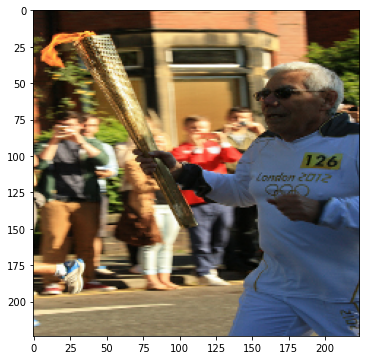

Predicted Caption:  a man in a blue shirt is walking down a street


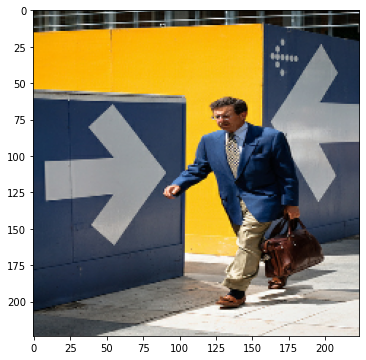

Predicted Caption:  a group of people are walking down a street


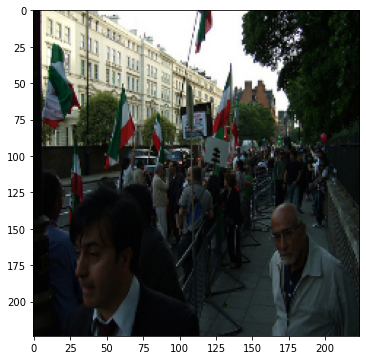

Predicted Caption:  a man is climbing a pole with a white shirt and blue jeans


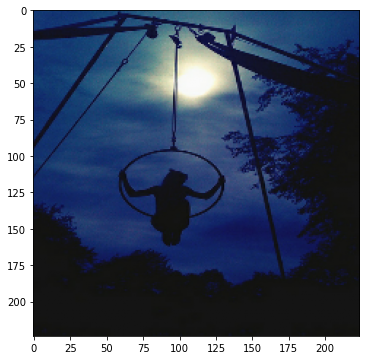

Predicted Caption:  a young boy is standing in a pool


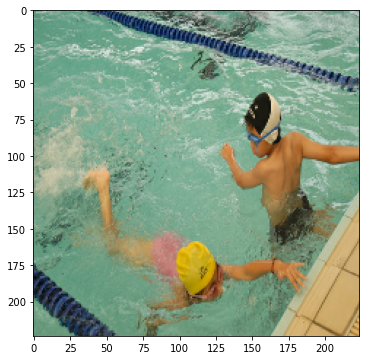

Predicted Caption:  a man in a red shirt is standing in front of a blue door


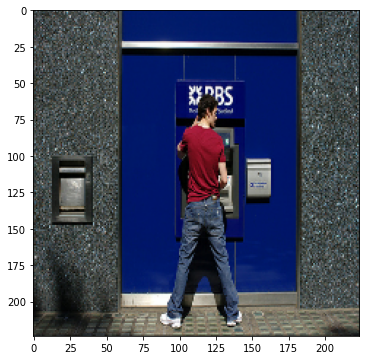

Predicted Caption:  a young girl in a white dress is standing in front of a white tent


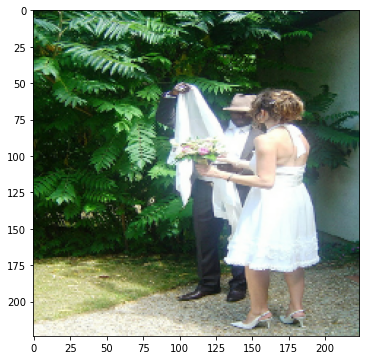

Predicted Caption:  a dog is running through the grass


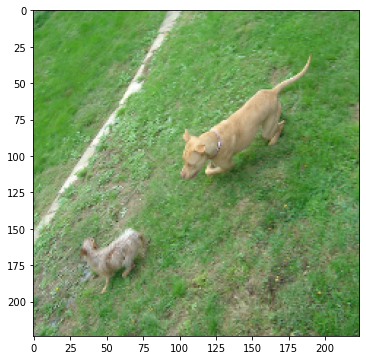

Predicted Caption:  a man in a suit is sitting on a bench


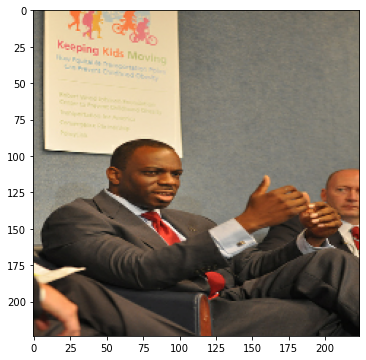

Predicted Caption:  a group of people are running on a track


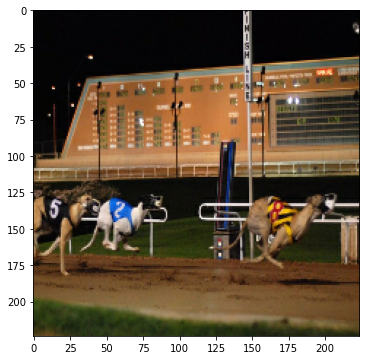

In [12]:
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()

In [22]:
with open("inference/train_config.json", "w") as f:
    json.dump(CONFIG, f)

In [16]:
save_tokenizer(tokenizer, "inference/tokenizer.keras")

In [23]:
!cp artifacts/model_weights.h5 inference/model_weights.h5
!ls inference/

model_weights.h5  tokenizer.keras  train_config.json
